In [1]:
%load_ext autotime

# Examine Target

This notebook look at some of the properties for a specific target as pulled from the sources listed generated in the [Source Detection](PIAA-Source-Detection-And-Filtering.ipynb) notebook. 

Note that this step is not necessary for the processing of an observation sequence as a whole but instead serves to highlight some of the issues with processing the images in a traditional fashion and thus helps motivate our unique algorithm.

In [2]:
import os

from matplotlib import cm
from matplotlib import pyplot as plt
plt.style.use('bmh')

import numpy as np
import pandas as pd
from collections import defaultdict

from tqdm import tqdm_notebook as tqdm

from piaa.utils import pipeline
from piaa.utils import helpers
from piaa.utils import plot
from piaa.utils.postgres import get_cursor
from piaa.utils import noise

from pocs.utils.images import fits as fits_utils
from pocs.utils.google.storage import PanStorage

from astropy.io import fits
from astropy.stats import sigma_clip, sigma_clipped_stats
from astropy import units as u

tess_cursor = get_cursor(port=5433, db_name='v6', db_user='postgres')

styles = plot.get_labelled_style_cycler(cmap='Paired')

time: 4.05 s


## Specify Target

Here we look up the target HD189733 by the 2MASS ID.

In [8]:
# picid = 435715608
# picid = 287933433
# picid = 287511722
# picid = 393243342
# picid = 343362027 # Hot pixel?
# picid = 11133916  # Same mag as HD189733
# picid = 86234511
# picid = helpers.get_star_info(twomass_id='20005694+2250490', cursor=tess_cursor).id
picid = 11135315

star_info = helpers.get_star_info(picid=picid, cursor=tess_cursor)

time: 91.6 ms


In [4]:
twomass = '20004370+2242391'

star_info = helpers.get_star_info(twomass_id=twomass, cursor=tess_cursor)
picid = star_info.id  # HD 189733

time: 47.8 ms


In [4]:
print(f'PICID: {picid}')

PICID: 11135315
time: 2.71 ms


#### Observation sources

We use the previously detected and filtered sources to examine our target. See the [Source-Detection](Source-Detection-And-Filtering.ipynb) for details.

In [4]:
base_dir = '/var/panoptes/images/fields/PAN012/358d0f/20180822T035809/'
# base_dir = '/var/panoptes/images/fields/PAN001/Hd189733/14d3bd/20180913T085704/'
source_filename = os.path.join(base_dir, f'point-sources-filtered.csv')

sources = pipeline.lookup_sources_for_observation(filename=source_filename).set_index(['picid'], append=True)

time: 1.25 s


For our target table we want to compare the flux as calculated from `sextractor` (which has no knowledge of the RGB array) with that pulled from a custom stamp.  `sextractor` uses a 6-pixel circular aperture  centered around the calculated centroid (the `x` and `y` values in our `sources` table) while our custom stamps will use an aperture that is sliced according to our rule of having a fixed pixel pattern. Here we use a 6-pixel aperture on our stamps for direct comparison with `sextractor` but the size can be vary.

In [5]:
camera_bias = 2048 * u.adu
stamp_size = 6 * u.pixel
num_pixels = (stamp_size**2).value

readout_noise = 10.5 * u.electron / u.pixel
gain = 1.5 * (u.electron / u.adu)
qe = 0.43

focal_length = 85 * u.mm
fstop = 1.4

aperture_area = focal_length / fstop
aperture_area = (np.pi * (aperture_area / 2)**2).to(u.m * u.m)

time: 9.48 ms


In [6]:
num_sources = len(sources.index.levels[1])

time: 1.1 ms


In [9]:
est_style = dict(ls='-.')

# http://classic.sdss.org/dr5/algorithms/sdssUBVRITransform.html

filter_colors = {
    'B': 'b',
    'V': 'g',
    'R': 'r'
}

mags = {
    'R': star_info.gaiamag, # star_info.vmag - 0.46*(star_info.bmag - star_info.vmag) + 0.11,    
    'V': star_info.vmag,    
    'B': star_info.bmag,
}
mags

{'R': 8.15755, 'V': 8.667, 'B': 9.978}

time: 8.08 ms


In [ ]:
est_counts = defaultdict(list)

for pid, target_table in tqdm(sources.groupby('picid'), total=num_sources):
    for idx, row in target_table.iterrows():
        date_obs= idx[0]

        airmass = row.airmass
        exptime = row.exp_time

        scint_index = helpers.scintillation_index(exptime, airmass, 100, correction_coeff=1.5)                    
        
        for filter_name, mag in mags.items():
            photons = noise.estimated_photon_count(
                magnitude=mags[filter_name], 
                aperture_area=aperture_area, 
                filter_name=filter_name,
                airmass=airmass,
                qe=qe
            ) * exptime

            # Apply RGGB pattern
            if filter_name == 'V':
                mult = 0.5
            else:
                mult = 0.25

            # Scale flux by number of pixels
            photons *= mult 

            # Get number of pixels for the filter
            n_pixels = int(num_pixels * mult)

            fill_factor = 0.5
            photons *= fill_factor

            transmission = 0.5
            photons *= transmission

            est_counts[pid].append({
                'date_obs': date_obs,
                'color': filter_colors[filter_name],
                'counts': int(photons / gain.value),
                'photon': int(photons),
                'photon_noise': 1/np.sqrt(photons),
                'readout_noise': (readout_noise * n_pixels).value / photons,
                'scint_noise': np.sqrt(scint_index)
            })

In [36]:
est_counts[picid]

[{'date_obs': Timestamp('2018-08-22 04:02:02'),
  'color': 'r',
  'counts': 7956,
  'photon': 11934,
  'photon_noise': 0.009153570791799733,
  'readout_noise': 0.00791795260372623,
  'scint_noise': 0.006058127606255141},
 {'date_obs': Timestamp('2018-08-22 04:02:02'),
  'color': 'g',
  'counts': 9311,
  'photon': 13967,
  'photon_noise': 0.008461285076350656,
  'readout_noise': 0.013531142232078845,
  'scint_noise': 0.006058127606255141},
 {'date_obs': Timestamp('2018-08-22 04:02:02'),
  'color': 'b',
  'counts': 2020,
  'photon': 3030,
  'photon_noise': 0.01816469222207343,
  'readout_noise': 0.03118084611289089,
  'scint_noise': 0.006058127606255141},
 {'date_obs': Timestamp('2018-08-22 04:07:23'),
  'color': 'r',
  'counts': 7963,
  'photon': 11944,
  'photon_noise': 0.009149765115258833,
  'readout_noise': 0.007911370057286506,
  'scint_noise': 0.005976839903954108},
 {'date_obs': Timestamp('2018-08-22 04:07:23'),
  'color': 'g',
  'counts': 9324,
  'photon': 13987,
  'photon_noise

time: 76.9 ms


In [34]:
pd.DataFrame(est_counts)

ValueError: arrays must all be same length

time: 33.4 ms


In [ ]:
est_counts = pd.DataFrame(photon_counts).set_index(['date_obs'])

In [131]:
est_counts.head()

,color,counts,photon,photon_noise,readout_noise,scint_noise
date_obs,,,,,,
2018-09-13 09:00:11,r,6800,10200,0.009901,0.009264,0.006798
2018-09-13 09:00:11,g,7946,11919,0.009160,0.015856,0.006798
2018-09-13 09:00:11,b,1719,2579,0.019690,0.036636,0.006798
2018-09-13 09:01:38,r,6798,10197,0.009903,0.009267,0.006832
2018-09-13 09:01:38,g,7942,11913,0.009162,0.015865,0.006832


time: 13.3 ms


In [133]:
print(star_info.bmag - star_info.vmag)
print(star_info.jmag - star_info.kmag)

1.311
0.7519999999999998
time: 6.94 ms


Text(0.5, 1.0, 'Overestimate of photon counts - 11135315')

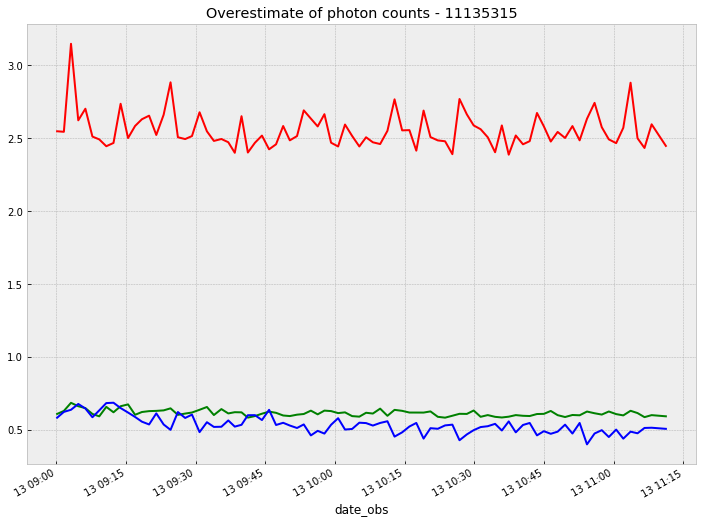

time: 587 ms


In [132]:
plt.figure(figsize=(12, 9))
for color in 'rgb':
    (est_counts.loc[est_counts.color == color].counts / target_table[f'flux_{color}']).plot(color=color)
    
plt.title(f'Overestimate of photon counts - {picid}')

In [58]:
target_table.tail()

,ra,dec,x,y,xpeak_image,ypeak_image,background,flux_best,fluxerr_best,mag_best,...,flux_stamp,flux_r,photon_noise_stamp_r,readout_stamp_r,flux_g,photon_noise_stamp_g,readout_stamp_g,flux_b,photon_noise_stamp_b,readout_stamp_b
obs_time,,,,,,,,,,,,,,,,,,,,,
2018-09-13 11:03:39,297.970646,26.396511,3910,1045,3910.4541,1045.2052,2071.935,21463.79,182.3471,14.1707,...,16588.340,2222.0,47.0,63.0,11387.0,106.0,126.0,2978.0,54.0,63.0
2018-09-13 11:05:09,297.970815,26.396485,3910,1046,3910.5054,1045.2488,2072.185,22103.95,180.5021,14.1388,...,17242.340,2557.0,50.0,63.0,11648.0,107.0,126.0,3036.0,55.0,63.0
2018-09-13 11:06:39,297.970348,26.396596,3910,1044,3910.5471,1043.7598,2072.101,22156.41,181.8522,14.1363,...,17602.364,2623.0,51.0,63.0,12171.0,110.0,126.0,2808.0,52.0,63.0
2018-09-13 11:08:11,297.970520,26.396499,3910,1040,3910.5535,1040.0470,2073.353,21397.14,178.7016,14.1741,...,17106.292,2455.0,49.0,63.0,11861.0,108.0,126.0,2788.0,52.0,63.0
2018-09-13 11:11:15,297.970478,26.396572,3910,1044,3910.4160,1043.9769,2072.637,21675.07,179.7548,14.1601,...,17355.068,2595.0,50.0,63.0,11955.0,109.0,126.0,2804.0,52.0,63.0


time: 32.8 ms


In [50]:
bin_minutes = 15

time: 636 µs


In [51]:
binned_est = est_counts.groupby('color').resample(f'{bin_minutes}T').mean()
binned_target = target_table.resample(f'{bin_minutes}T').mean()

time: 22.6 ms


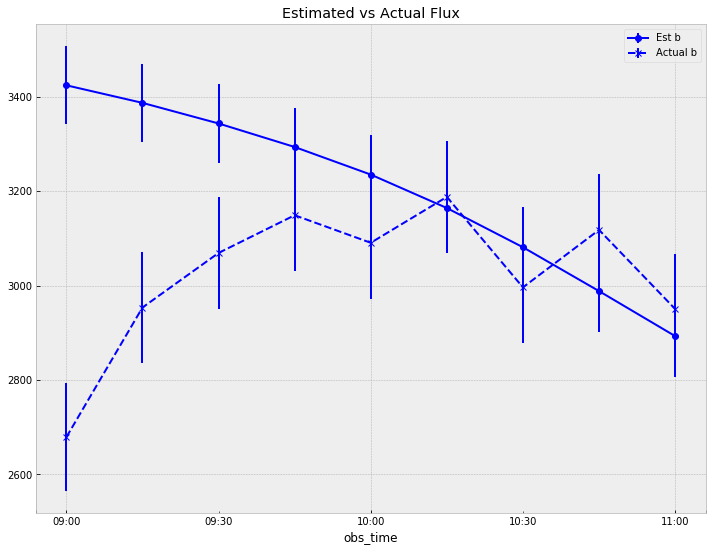

time: 464 ms


In [55]:
plt.figure(figsize=(12, 9))

for color in 'b':    
    color_data = binned_est.loc[color]
    
    est_noise = np.sqrt(color_data.photon_noise**2 + color_data.readout_noise**2 + color_data.scint_noise**2)

    color_data.counts.plot(marker='o', color=color, yerr=(color_data.counts * est_noise), label=f'Est {color}')
    binned_target[f'flux_{color}'].plot(yerr=(binned_target[f'photon_noise_stamp_{color}'] + binned_target[f'readout_stamp_{color}']),color=color, marker='x', ls='--', label=f'Actual {color}')
        
plt.title('Estimated vs Actual Flux')
plt.legend()

In [111]:
target_table.tail()

,ra,dec,x,y,xpeak_image,ypeak_image,background,flux_best,fluxerr_best,mag_best,...,flux_stamp,flux_r,photnoise_stamp_r,readout_stamp_r,flux_g,photnoise_stamp_g,readout_stamp_g,flux_b,photnoise_stamp_b,readout_stamp_b
obs_time,,,,,,,,,,,,,,,,,,,,,
2018-08-22 07:34:51,300.236369,22.846794,2156,1360,2156.4866,1359.5100,3200.374,25030.39,1690.015,14.0038,...,25685.536,2221.0,47.134213,63.0,21274.0,145.857012,126.0,2189.0,46.793525,63.0
2018-08-22 07:36:46,300.236655,22.846633,2156,1360,2156.4055,1359.8383,3146.595,27885.76,1660.445,13.8865,...,28564.580,2672.0,51.697631,63.0,23204.0,152.329544,126.0,2687.0,51.842502,63.0
2018-08-22 07:40:32,300.236723,22.846670,2156,1359,2156.3469,1358.8904,3164.040,26137.27,1797.247,13.9568,...,26612.560,2283.0,47.787446,63.0,21363.0,146.161828,126.0,2965.0,54.457690,63.0
2018-08-22 07:42:20,300.236330,22.846922,2156,1360,2156.4702,1359.6477,3052.553,28381.63,1623.530,13.8674,...,30651.092,3601.0,60.008524,63.0,23986.0,154.874291,126.0,3064.0,55.353618,63.0
2018-08-22 07:44:07,300.236543,22.846489,2156,1360,2156.4060,1359.9175,3167.001,25501.55,1582.051,13.9836,...,27480.964,2507.0,50.079846,63.0,22583.0,150.279679,126.0,2388.0,48.877306,63.0


time: 30.9 ms


In [ ]:
plt.figure(figsize=(12, 9))


for filter_name, est_photons in est_photon_counts.items():
    if not est_photons:
        continue
        
    print(filter_name, est_photons)
        
    color = filter_colors[filter_name]

    est_counts = (((est_photon_counts[filter_name] * (exp_time * u.second)) / gain) * (1 * u.electron) / (1 * u.photon)).value
    err_counts = np.sqrt(est_counts)

    print(f'Est counts at {exp_time}s: {est_counts:0.2f} {err_counts:.02f} ({(err_counts/est_counts):.02%}) ADU')

    scint_index = helpers.scintillation_index(exp_time, target_table.airmass.values, 100, correction_coeff=1.5)    
    
    s_noise = np.sqrt(scint_index)
    p_noise = (err_counts / est_counts)
    r_noise = target_table[f'readout_stamp_{color}']

    noise_level = np.sqrt(s_noise**2 + p_noise**2 + r_noise**2)
    
    plt.plot(target_table.index.values, r_noise, label=f'Est. Photon + scint {color}', color=color, **est_style)
#     plt.plot(target_table.index.values, noise_level, label=f'Est. Photon + scint {color}', color=color, **est_style)

    # for color in 'rgb':
    #     target_table[f'photnoise_stamp_{color}'].plot(color=color, label=f'Measured photon {color}')
    #     (target_table[f'photnoise_stamp_{color}'] / target_table[f'flux_{color}']).plot(color=color, label=f'Actual Photon Noise {color}')

plt.ylabel('Noise Level')
plt.title('Noise Sources')
plt.legend(fontsize=18)

In [114]:
target_table.head()

,ra,dec,x,y,xpeak_image,ypeak_image,background,flux_best,fluxerr_best,mag_best,...,flux_stamp,flux_r,photnoise_stamp_r,readout_stamp_r,flux_g,photnoise_stamp_g,readout_stamp_g,flux_b,photnoise_stamp_b,readout_stamp_b
obs_time,,,,,,,,,,,,,,,,,,,,,
2018-08-22 04:02:02,300.237426,22.846661,2156,1359,2155.9385,1358.6533,3429.876,22171.11,1747.121,14.1355,...,23582.464,197.0,14.039801,63.0,20813.0,144.267917,126.0,2572.0,50.716033,63.0
2018-08-22 04:07:23,300.236869,22.846899,2157,1360,2156.6675,1360.1027,3354.990,26296.18,1710.539,13.9503,...,26107.360,2068.0,45.476258,63.0,21588.0,146.929167,126.0,2451.0,49.508484,63.0
2018-08-22 04:09:11,300.236971,22.846837,2156,1360,2156.4971,1360.1202,3153.687,32677.42,1718.140,13.7144,...,32712.268,3228.0,56.822680,63.0,25047.0,158.264443,126.0,4435.0,66.601929,63.0
2018-08-22 04:10:58,300.236917,22.846907,2156,1360,2156.4124,1360.2173,3288.645,28851.19,1706.164,13.8496,...,28336.780,2090.0,45.718650,63.0,22754.0,150.845583,126.0,3492.0,59.094797,63.0
2018-08-22 04:12:46,300.237186,22.846793,2156,1358,2155.9214,1358.4288,3257.850,29774.37,1693.124,13.8154,...,29577.400,1845.0,42.957537,63.0,23688.0,153.911338,126.0,4043.0,63.587342,63.0


time: 32.2 ms
